In [1]:
import os
os.environ["KERAS_BACKEND"] = "jax"
import keras
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score

from sequential_ft_transformer.fttransformer import FTTransformer
from sequential_ft_transformer.preprocessing import sq_df_to_dataset, download_data
from sequential_ft_transformer.plotting import plot_importances, plot_training_hist


2024-04-07 21:41:09.578899: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Download Data

In [2]:
data_folder = "../data/"
seq_length = 1

In [3]:
CSV_HEADER = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education_num",
    "marital_status",
    "occupation",
    "relationship",
    "race",
    "gender",
    "capital_gain",
    "capital_loss",
    "hours_per_week",
    "native_country",
    "income_bracket",
]

train_data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
test_data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"

download_data(train_data_url, data_folder, "adult_train.csv")
download_data(test_data_url, data_folder, "adult_test.csv")

train_data = pd.read_csv(os.path.join(data_folder, "adult_train.csv"), header=None, names=CSV_HEADER)
test_data = pd.read_csv(os.path.join(data_folder, "adult_test.csv"), header=None, names=CSV_HEADER)

print(f"Train dataset shape: {train_data.shape}")
print(f"Test dataset shape: {test_data.shape}")

adult_train.csv already exists in ../data/
adult_test.csv already exists in ../data/
Train dataset shape: (32561, 15)
Test dataset shape: (16282, 15)


In [4]:
train_data.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Preprocess

In [5]:
# Column information
NUMERIC_FEATURES = ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
NUMERIC_FEATURES = sorted(NUMERIC_FEATURES)
CATEGORICAL_FEATURES = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'gender', 'native_country']
CATEGORICAL_FEATURES = sorted(CATEGORICAL_FEATURES)

FEATURES = sorted(list(NUMERIC_FEATURES) + list(CATEGORICAL_FEATURES))
LABEL = 'income_bracket'

In [6]:
# encoding as binary target
train_data[LABEL] = train_data[LABEL].apply(lambda x: int(x == ' >50K')) 
test_data[LABEL] = test_data[LABEL].apply(lambda x: int(x == ' >50K.'))

In [7]:
train_data = train_data.dropna()
test_data = test_data.dropna()

In [8]:
train_input = train_data[FEATURES]
train_labels = train_data[LABEL]

test_input = test_data[FEATURES]
test_labels = test_data[LABEL]

## Get Lookup Tables for Each Categorical Column

In [9]:
cat_lookups = dict()
feature_unique_counts = dict()
num_oov_indices = 1
for cat in CATEGORICAL_FEATURES:
    unique_values = list(np.unique(train_input[cat]).astype(str))
    feature_unique_counts[cat] = len(unique_values) + num_oov_indices
    lookup = keras.layers.StringLookup(vocabulary=unique_values, num_oov_indices=num_oov_indices)
    cat_lookups[cat] = lookup

2024-04-07 21:41:10.088740: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Convert Each Categorical String to an ID

In [10]:
for cat in CATEGORICAL_FEATURES:
    train_input[cat] = cat_lookups[cat](train_input[cat])
    test_input[cat] = cat_lookups[cat](test_input[cat])

/tmp/ipykernel_349454/1451819549.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_input[cat] = cat_lookups[cat](train_input[cat])
/tmp/ipykernel_349454/1451819549.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_input[cat] = cat_lookups[cat](test_input[cat])


In [11]:
train_input.loc[:, CATEGORICAL_FEATURES] = train_input[CATEGORICAL_FEATURES].astype(int)
test_input.loc[:, CATEGORICAL_FEATURES] = test_input[CATEGORICAL_FEATURES].astype(int)

train_input.loc[:, NUMERIC_FEATURES] = train_input[NUMERIC_FEATURES].astype(float)
test_input.loc[:, NUMERIC_FEATURES] = test_input[NUMERIC_FEATURES].astype(float)

In [12]:
train_labels = train_labels.to_frame(name=LABEL)
test_labels = test_labels.to_frame(name=LABEL)

In [13]:
x_train, x_val, y_train, y_val = train_test_split(train_input, train_labels, test_size=0.2)

## Create TF Datasets

In [14]:
batch_size = 1000
train_dataset = sq_df_to_dataset(
    x_train, 
    seq_length, 
    target_df=y_train, 
    target=LABEL, 
    categorical_features=CATEGORICAL_FEATURES, 
    numerical_features=NUMERIC_FEATURES, 
    batch_size=batch_size
)
val_dataset = sq_df_to_dataset(
    x_val, 
    seq_length, 
    target_df=y_val, 
    target=LABEL, 
    categorical_features=CATEGORICAL_FEATURES, 
    numerical_features=NUMERIC_FEATURES, 
    shuffle=False, # No shuffle
    batch_size=batch_size
)  
test_dataset = sq_df_to_dataset(
    test_input, 
    seq_length, 
    categorical_features=CATEGORICAL_FEATURES, 
    numerical_features=NUMERIC_FEATURES, 
    shuffle=False, 
    batch_size=batch_size) # No target, no shuffle

## Create bins for PLE

## Target-Aware Bins

In [15]:
from sklearn.tree import DecisionTreeClassifier

N_BINS = 10

t_bins_dict = dict()
for feature in NUMERIC_FEATURES:
    data = x_train[feature].values.reshape(-1, 1)
    y = y_train[LABEL].values

    dt = DecisionTreeClassifier(max_leaf_nodes=N_BINS)
    dt.fit(data, y)
    bins = np.unique(dt.tree_.threshold).astype("float32")
    t_bins_dict[feature] = bins

In [16]:
t_bins_dict

{'age': array([-2. , 24.5, 27.5, 29.5, 33.5, 36.5, 42.5, 54.5, 61.5, 71.5],
       dtype=float32),
 'capital_gain': array([-2.0000e+00,  5.7000e+01,  3.0480e+03,  3.1200e+03,  4.2435e+03,
         4.4010e+03,  5.1190e+03,  5.3165e+03,  6.6185e+03,  7.0735e+03],
       dtype=float32),
 'capital_loss': array([-2.0000e+00,  1.5515e+03,  1.5685e+03,  1.8205e+03,  1.8620e+03,
         1.8815e+03,  1.9785e+03,  2.1685e+03,  2.3845e+03,  3.3870e+03],
       dtype=float32),
 'education_num': array([-2. ,  1.5,  7.5,  8.5,  9.5, 10.5, 11.5, 12.5, 13.5, 14.5],
       dtype=float32),
 'hours_per_week': array([-2. , 34.5, 38.5, 41.5, 43.5, 45.5, 49.5, 65.5, 66.5, 90.5],
       dtype=float32)}

## Quantile Bins

In [17]:
N_BINS = 10

interval = 1 / N_BINS
intervals = np.arange(0.0, 1 + interval, interval)

q_bins_dict = dict()
for feature in NUMERIC_FEATURES:
    data = x_train[feature]

    bins = np.quantile(np.unique(data.values), intervals)
    q_bins_dict[feature] = bins

In [18]:
q_bins_dict

{'age': array([17. , 24.2, 31.4, 38.6, 45.8, 53. , 60.2, 67.4, 74.6, 81.8, 90. ]),
 'capital_gain': array([    0. ,  1419.5,  2079.2,  2418.9,  2963.4,  3467.5,  4536.4,
         5704.5,  7812.8, 14546.8, 99999. ]),
 'capital_loss': array([   0. ,  955.2, 1496.4, 1621.4, 1727.8, 1848. , 2034. , 2192.2,
        2304.8, 2487. , 4356. ]),
 'education_num': array([ 1. ,  2.5,  4. ,  5.5,  7. ,  8.5, 10. , 11.5, 13. , 14.5, 16. ]),
 'hours_per_week': array([ 1. , 10.1, 19.2, 28.3, 37.4, 46.5, 55.6, 64.7, 75.8, 87.9, 99. ])}

## Target-Aware PLE Numerical Embedding FT-Transformer

In [19]:
# Explanations need to be set to false until the following bug is fixed: https://github.com/keras-team/keras/issues/19303
EXPLANATIONS = False 
LEARNING_RATE = 0.0005
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 10

In [20]:
model = FTTransformer(
    out_dim=1,
    out_activation='sigmoid',
    feature_unique_counts=feature_unique_counts,
    numerical_features=NUMERIC_FEATURES,
    categorical_features=CATEGORICAL_FEATURES,
    seq_length=seq_length,
    numerical_embedding_type='ple',
    bins_dict=t_bins_dict,
    explainable=EXPLANATIONS    
)

optimizer = keras.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

loss = keras.losses.BinaryCrossentropy()
metrics = [keras.metrics.AUC(name="PR AUC", curve='PR')]
# Explanations need to be reworked once the bug is fixed
# if EXPLANATIONS:
#     loss_dict.update({"importances": None})
#     metrics_dict.update({"importances": None})
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics,
)

early = keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=20, restore_best_weights=True)
callback_list = [early]

/home/ubuntu22/repos/sequential-ft-transformer/venv/lib/python3.10/site-packages/keras/src/models/functional.py:107: UserWarning: When providing `inputs` as a dict, all keys in the dict must match the names of the corresponding tensors. Received key 'cat_inputs' mapping to value <KerasTensor shape=(None, 1, 8), dtype=float32, sparse=None, name=keras_tensor> which has name 'keras_tensor'. Change the tensor name to 'cat_inputs' (via `Input(..., name='cat_inputs')`)
  warnings.warn(
/home/ubuntu22/repos/sequential-ft-transformer/venv/lib/python3.10/site-packages/keras/src/models/functional.py:107: UserWarning: When providing `inputs` as a dict, all keys in the dict must match the names of the corresponding tensors. Received key 'numeric_inputs' mapping to value <KerasTensor shape=(None, 1, 5), dtype=float32, sparse=None, name=keras_tensor_1> which has name 'keras_tensor_1'. Change the tensor name to 'numeric_inputs' (via `Input(..., name='numeric_inputs')`)
  warnings.warn(


In [21]:
hist = model.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/10
25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - PR AUC: 0.2875 - loss: 0.6223

2024-04-07 21:41:23.591931: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - PR AUC: 0.2944 - loss: 0.6145

2024-04-07 21:41:32.772637: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 22s 490ms/step - PR AUC: 0.2975 - loss: 0.6110 - val_PR AUC: 0.6348 - val_loss: 0.4226
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - PR AUC: 0.7054 - loss: 0.3736 - val_PR AUC: 0.6727 - val_loss: 0.4079
Epoch 3/10
 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - PR AUC: 0.7441 - loss: 0.3228

2024-04-07 21:41:36.164530: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-07 21:41:36.208154: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - PR AUC: 0.7608 - loss: 0.3340 - val_PR AUC: 0.6547 - val_loss: 0.3870
Epoch 4/10
 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - PR AUC: 0.8094 - loss: 0.3131

2024-04-07 21:41:36.569170: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-07 21:41:36.616295: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - PR AUC: 0.7897 - loss: 0.3153 - val_PR AUC: 0.6473 - val_loss: 0.4020
Epoch 5/10
 8/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - PR AUC: 0.7857 - loss: 0.3252 

2024-04-07 21:41:36.958422: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-07 21:41:37.003147: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - PR AUC: 0.7844 - loss: 0.3181 - val_PR AUC: 0.6501 - val_loss: 0.3804
Epoch 6/10
 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - PR AUC: 0.8308 - loss: 0.3189

2024-04-07 21:41:37.266693: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-07 21:41:37.308938: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - PR AUC: 0.7905 - loss: 0.3177 - val_PR AUC: 0.6567 - val_loss: 0.3889
Epoch 7/10
 7/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - PR AUC: 0.8055 - loss: 0.3241 

2024-04-07 21:41:37.674405: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-07 21:41:37.724427: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - PR AUC: 0.7958 - loss: 0.3136 - val_PR AUC: 0.6596 - val_loss: 0.4037
Epoch 8/10
 7/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - PR AUC: 0.7744 - loss: 0.3192 

2024-04-07 21:41:37.990685: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-07 21:41:38.034930: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - PR AUC: 0.7852 - loss: 0.3101 - val_PR AUC: 0.6658 - val_loss: 0.3756
Epoch 9/10
 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - PR AUC: 0.7461 - loss: 0.3468

2024-04-07 21:41:38.302527: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-07 21:41:38.344746: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - PR AUC: 0.7845 - loss: 0.3120 - val_PR AUC: 0.6644 - val_loss: 0.3801
Epoch 10/10
 7/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - PR AUC: 0.7862 - loss: 0.3126 

2024-04-07 21:41:38.701677: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-07 21:41:38.743229: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - PR AUC: 0.7937 - loss: 0.3050 - val_PR AUC: 0.6646 - val_loss: 0.3895


2024-04-07 21:41:39.011830: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-07 21:41:39.052523: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


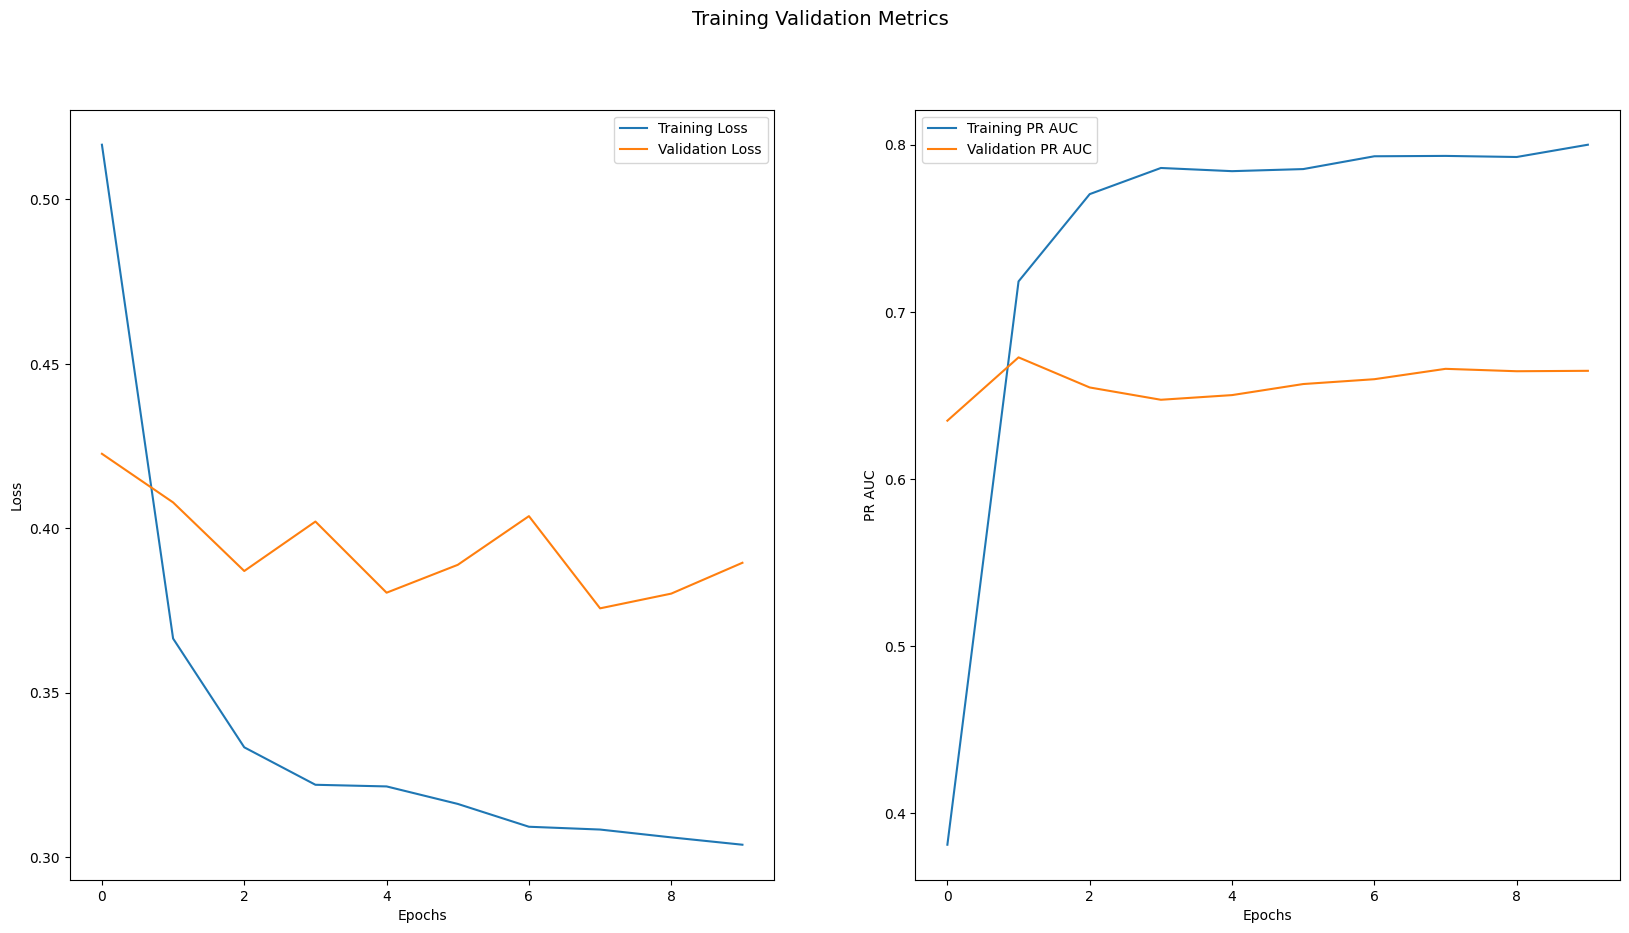

In [22]:
hist_plot = plot_training_hist(hist.history, EXPLANATIONS)

In [23]:
preds = model.predict(test_dataset)
flat_preds = preds.ravel()
print("Test ROC AUC:", np.round(roc_auc_score(test_data[LABEL], flat_preds), 4))
print("Test PR AUC:", np.round(average_precision_score(test_data[LABEL], flat_preds), 4))
print("Test Accuracy:", np.round(accuracy_score(test_data[LABEL], flat_preds > 0.5), 4))

# Reported accuracy - 0.858

 1/17 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step

2024-04-07 21:41:40.715933: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step
Test ROC AUC: 0.868
Test PR AUC: 0.6466
Test Accuracy: 0.8066


## Explainability

In [24]:
# if 'importances' in preds.keys():
#     importances = preds['importances']
#     importances_df = pd.DataFrame(importances[:, :-1], columns = FEATURES)
#     importances_fig, total_importances = plot_importances(
#         importances_df, 
#         title="Importances for FT-Transformer"
#     )

## Quantile PLE Transformer

In [25]:
model = FTTransformer(
    out_dim=1,
    out_activation='sigmoid',
    feature_unique_counts=feature_unique_counts,
    numerical_features=NUMERIC_FEATURES,
    categorical_features=CATEGORICAL_FEATURES,
    seq_length=seq_length,
    numerical_embedding_type='ple',
    bins_dict=q_bins_dict,
    explainable=EXPLANATIONS    
)

optimizer = keras.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

loss = keras.losses.BinaryCrossentropy()
metrics = [keras.metrics.AUC(name="PR AUC", curve='PR')]
# Explanations need to be reworked once the bug is fixed
# if EXPLANATIONS:
#     loss_dict.update({"importances": None})
#     metrics_dict.update({"importances": None})
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics,
)

early = keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=20, restore_best_weights=True)
callback_list = [early]

/home/ubuntu22/repos/sequential-ft-transformer/venv/lib/python3.10/site-packages/keras/src/models/functional.py:107: UserWarning: When providing `inputs` as a dict, all keys in the dict must match the names of the corresponding tensors. Received key 'cat_inputs' mapping to value <KerasTensor shape=(None, 1, 8), dtype=float32, sparse=None, name=keras_tensor_35> which has name 'keras_tensor_35'. Change the tensor name to 'cat_inputs' (via `Input(..., name='cat_inputs')`)
  warnings.warn(
/home/ubuntu22/repos/sequential-ft-transformer/venv/lib/python3.10/site-packages/keras/src/models/functional.py:107: UserWarning: When providing `inputs` as a dict, all keys in the dict must match the names of the corresponding tensors. Received key 'numeric_inputs' mapping to value <KerasTensor shape=(None, 1, 5), dtype=float32, sparse=None, name=keras_tensor_36> which has name 'keras_tensor_36'. Change the tensor name to 'numeric_inputs' (via `Input(..., name='numeric_inputs')`)
  warnings.warn(


In [26]:
hist = model.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/10
24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - PR AUC: 0.4991 - loss: 0.4741

2024-04-07 21:41:51.174970: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - PR AUC: 0.5123 - loss: 0.4675

2024-04-07 21:41:57.953566: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 363ms/step - PR AUC: 0.5161 - loss: 0.4657 - val_PR AUC: 0.5843 - val_loss: 0.4058
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - PR AUC: 0.7116 - loss: 0.3509 - val_PR AUC: 0.5940 - val_loss: 0.4127
Epoch 3/10
 7/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - PR AUC: 0.7279 - loss: 0.3456 

2024-04-07 21:42:00.602861: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-07 21:42:00.646018: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - PR AUC: 0.7360 - loss: 0.3358 - val_PR AUC: 0.5907 - val_loss: 0.5072
Epoch 4/10
 7/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - PR AUC: 0.7681 - loss: 0.3273 

2024-04-07 21:42:00.908302: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-07 21:42:00.954448: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - PR AUC: 0.7681 - loss: 0.3235 - val_PR AUC: 0.5989 - val_loss: 0.4434
Epoch 5/10
 8/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - PR AUC: 0.7528 - loss: 0.3192 

2024-04-07 21:42:01.228611: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-07 21:42:01.273325: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - PR AUC: 0.7657 - loss: 0.3198 - val_PR AUC: 0.5971 - val_loss: 0.5034
Epoch 6/10
 7/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - PR AUC: 0.7783 - loss: 0.3699 

2024-04-07 21:42:01.532783: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-07 21:42:01.575532: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - PR AUC: 0.7599 - loss: 0.3453 - val_PR AUC: 0.6294 - val_loss: 0.4590
Epoch 7/10
 7/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - PR AUC: 0.7869 - loss: 0.3013 

2024-04-07 21:42:01.845499: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-07 21:42:01.888454: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - PR AUC: 0.7896 - loss: 0.3067 - val_PR AUC: 0.6344 - val_loss: 0.4157
Epoch 8/10
 8/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - PR AUC: 0.8040 - loss: 0.3086 

2024-04-07 21:42:02.170561: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-07 21:42:02.214590: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - PR AUC: 0.7974 - loss: 0.3065 - val_PR AUC: 0.6170 - val_loss: 0.4790
Epoch 9/10
 7/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - PR AUC: 0.7812 - loss: 0.3185 

2024-04-07 21:42:02.471720: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-07 21:42:02.515723: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - PR AUC: 0.7871 - loss: 0.3113 - val_PR AUC: 0.6235 - val_loss: 0.4652
Epoch 10/10
 7/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - PR AUC: 0.7922 - loss: 0.3094 

2024-04-07 21:42:02.777526: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-07 21:42:02.827066: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - PR AUC: 0.7884 - loss: 0.3078 - val_PR AUC: 0.6098 - val_loss: 0.4543


2024-04-07 21:42:03.088602: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-07 21:42:03.136607: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


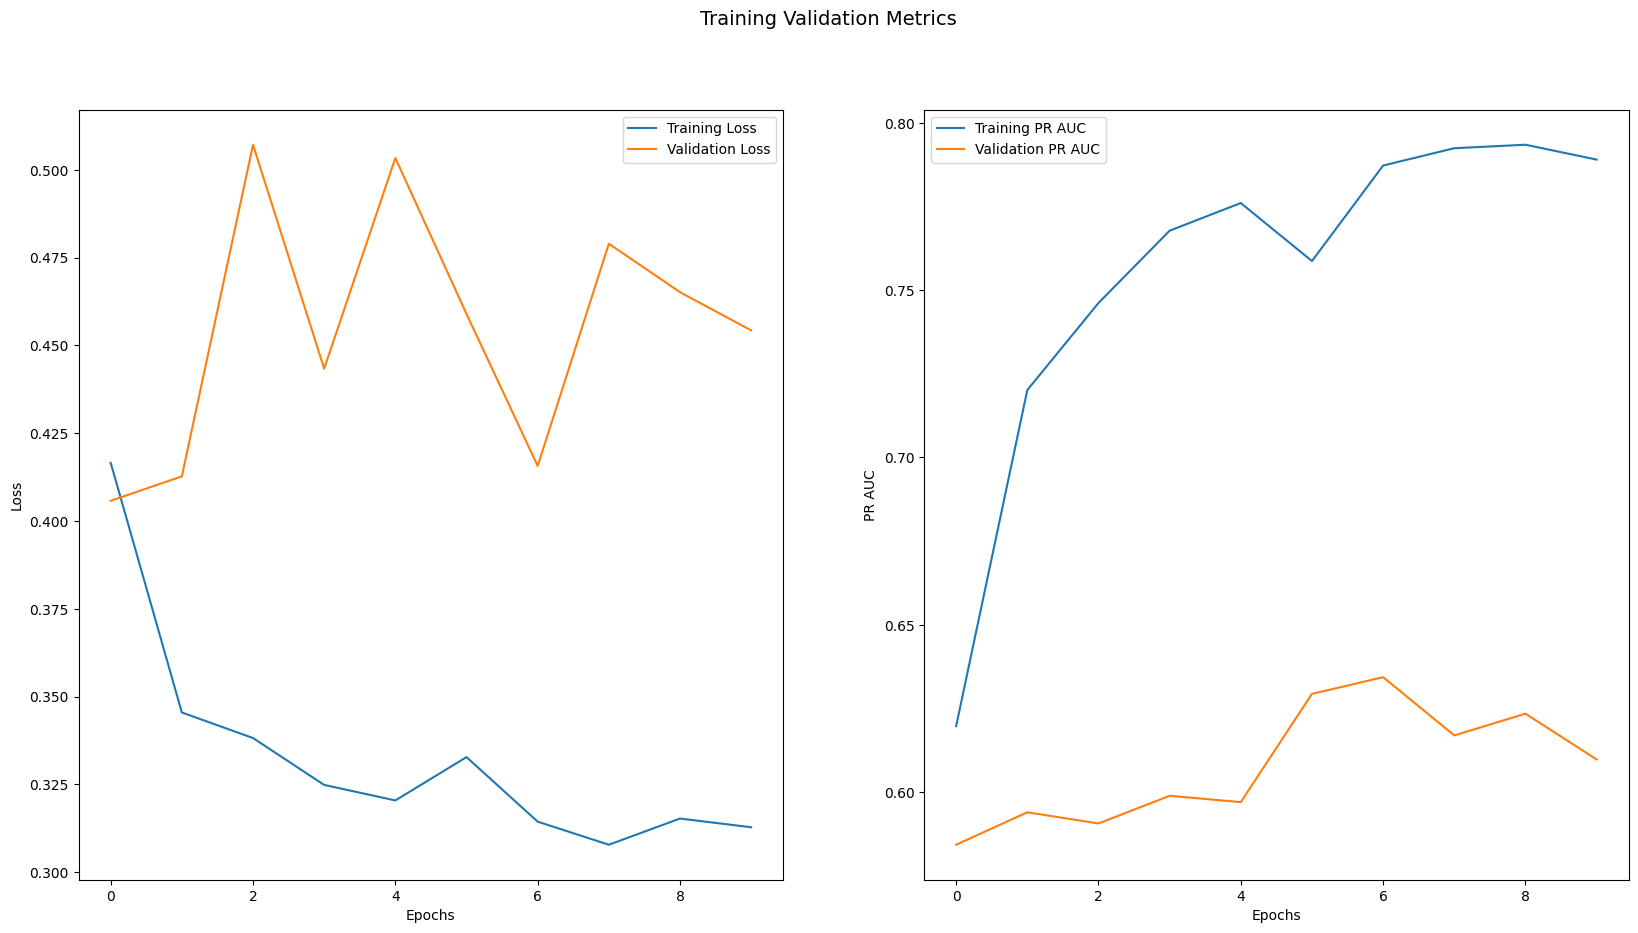

In [27]:
hist_plot = plot_training_hist(hist.history, EXPLANATIONS)

In [28]:
preds = model.predict(test_dataset)
flat_preds = preds.ravel()
print("Test ROC AUC:", np.round(roc_auc_score(test_data[LABEL], flat_preds), 4))
print("Test PR AUC:", np.round(average_precision_score(test_data[LABEL], flat_preds), 4))
print("Test Accuracy:", np.round(accuracy_score(test_data[LABEL], flat_preds > 0.5), 4))

# Reported accuracy - 0.858

 1/17 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step

2024-04-07 21:42:04.834819: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step
Test ROC AUC: 0.8567
Test PR AUC: 0.6251
Test Accuracy: 0.8184


## Explainability

In [29]:
# if 'importances' in preds.keys():
#     importances = preds['importances']
#     importances_df = pd.DataFrame(importances[:, :-1], columns = FEATURES)
#     importances_fig, total_importances = plot_importances(
#         importances_df, 
#         title="Importances for FT-Transformer"
#     )